In [1]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
from datetime import date
import re
import os
import matplotlib as np
from matplotlib import pyplot as plt
from numpy import random
#from scipy.stats import uniform
import seaborn as sns
%matplotlib inline
#from scipy.stats import poisson,skellam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


In [2]:
def get_url_content(url):
    url = "https://www.transfermarkt.com" + url
    response = requests.get(url, headers={'User-Agent': 'Custom'})
    return BeautifulSoup(response.content, 'html.parser')

In [3]:
#### Competitions table #####
%store -z ## To delete all stored variables from storage

#Competitions = ["Bundesliga", "Primier League", "La Liga", "Seria A", "Ligue 1", "Liga NOS",
#               "Champions League", "Europa League", "FIFA World Cup", "Euro", "WORLD CUP QUALIFICATION EUROPE",
#               "INTERNATIONAL FRIENDLIES", "UEFA NATIONS LEAGUE", "COPA AMÉRICA"]

Competitions = ["Bundesliga", "Primier League", "La Liga", "Seria A", "Ligue 1"]

competitions_df = pd.DataFrame(Competitions, columns = ['Competition'])
competitions_df = competitions_df.style.set_properties(**{'text-align': 'left'})
competitions_df = competitions_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

#competitions_df
display(competitions_df)
competition_to_learn_num = int(input("Please choose the competition's number you want to learn: "))


Seasons = ["19/20", "18/19", "17/18", "16/17", "15/16"]

seasons_df = pd.DataFrame(Seasons, columns = ['Seasons'])
seasons_df = seasons_df.style.set_properties(**{'text-align': 'left'})
seasons_df = seasons_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

#competitions_df
display(seasons_df)
season_to_learn_num = int(input("Please choose the season's number you want to learn: "))



,Competition
0,Bundesliga
1,Primier League
2,La Liga
3,Seria A
4,Ligue 1


Please choose the competition's number you want to learn: 0


,Seasons
0,19/20
1,18/19
2,17/18
3,16/17
4,15/16


Please choose the season's number you want to learn: 0


In [4]:
#### Switcher to get the chosen competition's url #####

def competition_switcher(x):
    switcher = {
        0: ["bundesliga","L1"],  #0: "",        #Bundesliga
        1: ["premier-league","GB1"],        #Primier League
        2: ["laliga","ES1"],        #La Liga
        3: ["serie-a","IT1"],        #Seria A
        4: ["ligue-1","FR1"]        #Ligue 1
    }
    return switcher.get(x, "Invalid Competiton Number")

def season_switcher(x):
    switcher = {
        0: '2019',   #19/20
        1: '2018',   #18/19
        2: '2017',   #17/18
        3: '2016',   #16/17
        4: '2015'    #15/16
    }
    return switcher.get(x, "Invalid Season Number")


In [5]:
#### Get the chosen competition's page #####
    
competition_comps = competition_switcher(competition_to_learn_num)
season_year = season_switcher(season_to_learn_num)

competition_url = "https://www.transfermarkt.com/" + competition_comps[0] + "/spieltagtabelle/wettbewerb/" + competition_comps[1] + "?saison_id=" + season_year + "&spieltag=1"

response = requests.get(competition_url, headers={'User-Agent': 'Custom'})
competition_url_content = BeautifulSoup(response.content, 'html.parser')

In [6]:
#### Get teams url #####

competition_url = "https://www.transfermarkt.com/" + competition_comps[0] + "/tabelle/wettbewerb/" + competition_comps[1] + "/saison_id/" + season_year

response = requests.get(competition_url, headers={'User-Agent': 'Custom'})
competition_url_content = BeautifulSoup(response.content, 'html.parser')
print(competition_url)
teams_url_comps = []

a = competition_url_content.find("div", class_= "responsive-table").find("table").find("tbody")

for tr in a.findAll("tr"):
    temp = tr.find("td", class_= "no-border-links hauptlink").find("a", class_= "vereinprofil_tooltip")
    #temp = tr.find("td", class_= "no-border-links hauptlink")
    team_name = temp.get_text(strip=True)
    team_full_link = temp.get('href')
    team_partitioned_link = team_full_link.partition('/')
    team_partitioned_link = team_partitioned_link[2]
    team_partitioned_link = team_partitioned_link.partition('/')
    team_url_name = team_partitioned_link[0]
    team_id = temp.get("id")
    teams_url_comps.append(tuple([team_name, team_url_name,team_id]))

https://www.transfermarkt.com/bundesliga/tabelle/wettbewerb/L1/saison_id/2019


In [7]:
#### Get teams market values #####

teams_values_url = "https://www.transfermarkt.com/" + competition_comps[0] + "/marktwerteverein/wettbewerb/" + competition_comps[1] + "/plus/?stichtag=" + season_year + "-09-01"

response = requests.get(teams_values_url, headers={'User-Agent': 'Custom'})
teams_values_url_content = BeautifulSoup(response.content, 'html.parser')

teams_stats_sum = []

for each_tuple in teams_url_comps:
    team_name = each_tuple[0]
    teams_values_url = "https://www.transfermarkt.com/" + each_tuple[1] + "/kader/verein/" + each_tuple[2] + "/plus/0/galerie/0?saison_id=" + season_year
    response = requests.get(teams_values_url, headers={'User-Agent': 'Custom'})
    teams_values_url_content = BeautifulSoup(response.content, 'html.parser')
    
    a = teams_values_url_content.find("div", class_= "large-4 columns").find("div", class_= "box").find("table").find("tfoot").find("tr")
    td_list = a.findAll("td")
    team_value = td_list[2].get_text(strip=True)
    team_value_final = float(re.search(r'\d+\.\d+', team_value).group())
    if 'm' in team_value.lower():
        team_value_final *= 1000000 
    elif 'b' in team_value.lower():
        team_value_final *= 1000000000
    team_value_final = int(team_value_final)
    teams_stats_sum.append([team_name, team_value_final, 0, 0, 0, 0, 0, each_tuple[2]])

while len(teams_stats_sum) < 20:
    teams_stats_sum.append([0, 0, 0, 0, 0, 0, 0, 0])
    
# (team_name, team_value, current_position, home_games_results, away_games_results, home_games_counter, away_games_counter, team_id)

In [8]:
#### Switcher to get the team index in the tuples array #####

def team_index_switcher(x):
    switcher = {
        teams_stats_sum[0][0]: 0,
        teams_stats_sum[1][0]: 1,
        teams_stats_sum[2][0]: 2,
        teams_stats_sum[3][0]: 3,
        teams_stats_sum[4][0]: 4,
        teams_stats_sum[5][0]: 5,
        teams_stats_sum[6][0]: 6,
        teams_stats_sum[7][0]: 7,
        teams_stats_sum[8][0]: 8,
        teams_stats_sum[9][0]: 9,
        teams_stats_sum[10][0]: 10,
        teams_stats_sum[11][0]: 11,
        teams_stats_sum[12][0]: 12,
        teams_stats_sum[13][0]: 13,
        teams_stats_sum[14][0]: 14,
        teams_stats_sum[15][0]: 15,
        teams_stats_sum[16][0]: 16,
        teams_stats_sum[17][0]: 17,
        teams_stats_sum[18][0]: 18,
        teams_stats_sum[19][0]: 19

    }
    return switcher.get(x, "Invalid Index Number")

In [9]:
#### Get all season matches results ####
    
season_matches_results_url = "https://www.transfermarkt.com/" + competition_comps[0] + "/gesamtspielplan/wettbewerb/" + competition_comps[1] + "/saison_id/" + season_year
response = requests.get(season_matches_results_url, headers={'User-Agent': 'Custom'})
season_matches_results_url_content = BeautifulSoup(response.content, 'html.parser')    

base_url = "https://www.transfermarkt.com"
df_train_rows = []
df_target_rows = []

print("Please wait, this may take a few minutes...")

for each_matchday in season_matches_results_url_content.findAll("div", class_= "large-6 columns"):
    curr_matchday_table = each_matchday.find("table")
    if curr_matchday_table != None:
        curr_matchday_tbody = curr_matchday_table.find("tbody")
        for each_row in curr_matchday_tbody.findAll("tr", class_=None): #("tr")
            home_team_points = 0
            away_team_points = 0
            last_matches_between_teams_url = base_url
            
            for game_result in each_row.findAll("td", class_= "zentriert hauptlink"):
                res = game_result.find("a", class_= "ergebnis-link").get_text(strip=True)
                res = res.partition(':')
                home_team_goals = int(re.search(r'\d+', res[0]).group())
                away_team_goals = int(re.search(r'\d+', res[2]).group())
                if home_team_goals > away_team_goals:
                    home_team_points = 2
                    df_target_rows.append(2)
                elif home_team_goals < away_team_goals:
                    away_team_points = 2
                    df_target_rows.append(0)
                else:
                    home_team_points = 1
                    away_team_points = 1
                    df_target_rows.append(1)
                last_matches_between_teams_url += game_result.find("a", class_= "ergebnis-link").get('href')
            
            for home_team_stats in each_row.findAll("td", class_= "text-right no-border-rechts hauptlink"):
                home_team_position = home_team_stats.find("span", class_= "tabellenplatz").get_text(strip=True)
                home_team_position = int(re.search(r'\d+', home_team_position).group())
                home_team_name = home_team_stats.find("a", class_= "vereinprofil_tooltip").get_text(strip=True)
                switcher_home_num = team_index_switcher(home_team_name)
                try:      # to prevent divide by zero
                    home_team_curr_points =  teams_stats_sum[switcher_home_num][3] / teams_stats_sum[switcher_home_num][5]
                except:
                    home_team_curr_points = 0

                teams_stats_sum[switcher_home_num][2] = home_team_position
                teams_stats_sum[switcher_home_num][5] += 1
                teams_stats_sum[switcher_home_num][3] += home_team_points
                #print(teams_stats_sum[switcher_home_num])
                
            for away_team_stats in each_row.findAll("td", class_= "no-border-links hauptlink"): #away team
                away_team_position = away_team_stats.find("span", class_= "tabellenplatz").get_text(strip=True)
                away_team_position = int(re.search(r'\d+', away_team_position).group())
                away_team_name = away_team_stats.find("a", class_= "vereinprofil_tooltip").get_text(strip=True)
                switcher_away_num = team_index_switcher(away_team_name)
                try:      # to prevent divide by zero
                    away_team_curr_points = teams_stats_sum[switcher_away_num][4] / teams_stats_sum[switcher_away_num][6]
                except:
                    away_team_curr_points = 0   
                
                teams_stats_sum[switcher_away_num][2] = away_team_position
                teams_stats_sum[switcher_away_num][6] += 1
                teams_stats_sum[switcher_away_num][4] += away_team_points
                #print(teams_stats_sum[switcher_away_num])
                #print("---------------------------")
            
            last_matches_between_teams_url = re.sub('/index/', '/vorbericht/', last_matches_between_teams_url)
            response = requests.get(last_matches_between_teams_url, headers={'User-Agent': 'Custom'})
            last_matches_between_teams_url_content = BeautifulSoup(response.content, 'html.parser')
            
            last_matches_between_teams = last_matches_between_teams_url_content.find("div", class_="table-header",
                          text=re.compile('Last')).find_parent("div", class_="box")
            
            
            curr_match_home_team_points = 0
            curr_match_away_team_points = 0
            match_results = last_matches_between_teams.find("tbody")
            for each_match_result in match_results.findAll("tr"):
                curr_match_competition = each_match_result.find("td", class_= "zentriert").find('img').get('title') # want to get only league games
                curr_match_competition = curr_match_competition.partition('.')[0]
                if curr_match_competition.lower() == competition_comps[1].lower():
                    temp = each_match_result.find("td", class_="no-border-links")
                    curr_home_team_id = temp.find("a")['id']    #temp.get("id")
                    home_team_id = teams_stats_sum[switcher_home_num][7]
                
                    if home_team_id == curr_home_team_id:
                        curr_match_res = each_match_result.find("a", title="Match report", class_="ergebnis-link").get_text(strip=True)
                        curr_match_res = curr_match_res.partition(':')
                        curr_match_home_team_goals = int(re.search(r'\d+', curr_match_res[0]).group())
                        curr_match_away_team_goals = int(re.search(r'\d+', curr_match_res[2]).group())
                        if curr_match_home_team_goals > curr_match_away_team_goals:
                            curr_match_home_team_points += 2
                        elif curr_match_home_team_goals < curr_match_away_team_goals:
                            curr_match_away_team_points += 2
                        else:
                            curr_match_home_team_points += 1
                            curr_match_away_team_points += 1

            
            ### df columns building ###
            
            last_matches_between_teams_results = curr_match_home_team_points - curr_match_away_team_points
            positions = teams_stats_sum[switcher_away_num][2] - teams_stats_sum[switcher_home_num][2]
            values = teams_stats_sum[switcher_home_num][1] / teams_stats_sum[switcher_away_num][1]

            last_each_team_results = home_team_curr_points - away_team_curr_points
            df_train_rows.append(tuple([values, positions, last_each_team_results, last_matches_between_teams_results]))

Please wait, this may take a few minutes...


In [10]:
##### Train df #####

df_train = pd.DataFrame(df_train_rows, columns = ['Values', 'Positions', "Last teams results", 'Last results between teams'])
df_train = df_train.style.set_properties(**{'text-align': 'left'})

df_train = df_train.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

#display(df_train)


In [11]:
#### Target df #####

df_target = pd.DataFrame(df_target_rows, columns = ['Match Result']) # 2- Home, 1- Draw, 0- Away
df_target = df_target.style.set_properties(**{'text-align': 'left'})

df_target = df_target.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

#display(df_target)


In [12]:
#### Logistic Regression ####
lr_X = df_train_rows
lr_y = df_target_rows
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(lr_X, lr_y)
lr_model_test_results = metrics.accuracy_score(y_true = lr_y, y_pred = lr_model.predict(lr_X))
#print('Logistic Regression - Accuracy on test data= ', metrics.accuracy_score(y_true = lr_y, y_pred = lr_model.predict(lr_X)))


#### Naive Bayes ####

nb_X = df_train_rows
nb_y = df_target_rows
XTrain, XTest, yTrain, yTest = train_test_split(nb_X, nb_y, random_state=1, test_size=0.3) ## 30% test 70% training

nb_model = GaussianNB()
nb_model.fit(XTrain,yTrain)

y_pred = nb_model.predict(XTest) # results prediction
y_pred_train = nb_model.predict(XTrain)

nb_model_test_results = metrics.accuracy_score(y_true = yTest, y_pred = y_pred)
#print('Naive Bayes - Accuracy on Train data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
#print('Naive Bayes - Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

#### Best ####
#print('Logistic Regression test result= ', lr_model_test_results)
#print('Naive Bayes test result= ', nb_model_test_results)
if (lr_model_test_results > nb_model_test_results):
    best_model = lr_model
else:
    best_model = nb_model
print('Best test result= ', best_model)


Best test result=  LogisticRegression(random_state=0, solver='liblinear')


In [13]:
#### Switcher to choose ML algorithm #####

def ml_algo_switcher(x):
    switcher = {
        0: best_model,    #Best
        1: lr_model,      #Logistic Regression
        2: nb_model       #Naive Bayes
    }
    return switcher.get(x, "Invalid ML algorithm's number")


In [14]:
#### ML algorithm choise #####

ML_Algotihms = ["Best", "Logistic Regression", "Naive Bayes"]


ml_algorithm_df = pd.DataFrame(ML_Algotihms, columns = ['ML_Algorithms'])
ml_algorithm_df = ml_algorithm_df.style.set_properties(**{'text-align': 'left'})

ml_algorithm_df = ml_algorithm_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])


display(ml_algorithm_df)

chosen_ml_algorithm_num = int(input("Please choose the ML algorithm's number you want to use: "))

chosen_model = ml_algo_switcher(chosen_ml_algorithm_num)
%store chosen_model
print(chosen_model)

,ML_Algorithms
0,Best
1,Logistic Regression
2,Naive Bayes


Please choose the ML algorithm's number you want to use: 0
Stored 'chosen_model' (LogisticRegression)
LogisticRegression(random_state=0, solver='liblinear')


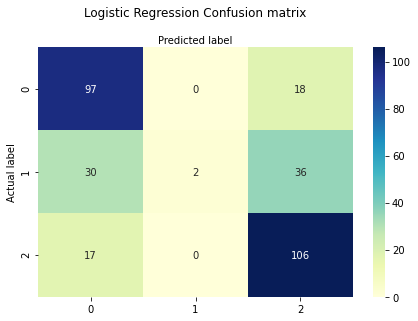

Logistic Regression - Accuracy on test data=  0.6699346405228758


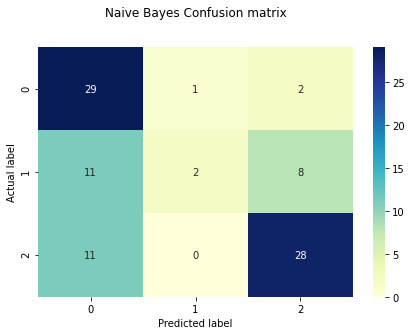

Naive Bayes - Accuracy on Train data=  0.5700934579439252
Naive Bayes - Accuracy on test data=  0.6413043478260869


In [15]:
#### Visualizing Confusion Matrix using Heatmap ####
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


lr_cnf_matrix = metrics.confusion_matrix(lr_y, lr_model.predict(lr_X))
nb_cnf_matrix = metrics.confusion_matrix(yTest, y_pred)


class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap for lr_cnf_matrix (Logistic Regression)
sns.heatmap(pd.DataFrame(lr_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Logistic Regression Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
print('Logistic Regression - Accuracy on test data= ', lr_model_test_results)
#print('Logistic Regression - Accuracy on test data= ', metrics.accuracy_score(y_true = lr_y, y_pred = lr_model.predict(lr_X)))

# create heatmap for nb_cnf_matrix (Naive Bayes)
sns.heatmap(pd.DataFrame(nb_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Naive Bayes Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
print('Naive Bayes - Accuracy on Train data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
print('Naive Bayes - Accuracy on test data= ', nb_model_test_results)
#print('Naive Bayes - Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))


# on the first heat map we can see that 97,2, 106 are actual predictions, while the rest are incorrect predictions.
# we can see that with the Logistic Regression model, from 306 matches we successfully predicted 205 right results
# and 101 wrong. Accuracy of  0.669 (67%)


# on the first heat map we can see that 29,2, 28 are actual predictions, while the rest are incorrect predictions.
# we can see that with the Naive Bayes model, from 92 matches we successfully predicted 59 right results
# and 33 wrong. Accuracy of  0.641 (64%)